In [1]:
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from myutils import *  # restore(), get_filename()
import ptrReader
import pytools as pt
#from particle_tracer import sample_evdf         # CAUSES AN ERROR? seemingly related to the argument parser

#import os
#os.environ['PATH'] = "/wrk-vakka/group/spacephysics/proj/appl/tex-basic/texlive/2023/bin/x86_64-linux:" + os.environ['PATH']
#print(os.environ["PATH"])

R_EARTH = 6.371e6




Using backend module://matplotlib_inline.backend_inline
Using matplotlib version 3.7.1


In [2]:
# copied directly from utils/particle_tracer.py, because importing didn't work

def sample_evdf(vlsvReader, x, v):
    '''
    given a vlsvReader object, find the value of the distribution function f
    at a given coordinate in position/velocity phase space: f(x,v)
    assumes a maxwellian f, and polytropic equation of state (adiabatic index 5/3)

    Inputs:
    x: position vector [m], 3-element array
    v: velocity vector [m/s], 3-element array
    '''
    gamma = 5. / 3.
    try:
        # Generally, it should be possible to find parameters with vlsvReader.get_config().
        # Tested: FHA works, but not EGL
        n0 = float(f.get_config()['proton_Magnetosphere']['rho'][0])
        T0 = 1.380649e-23 * float(f.get_config()['proton_Magnetosphere']['T'][0])
    except:
        n0 = 1e6              # EGI, EGL, FHA [m^-3]. 
        T0 = 1.380649e-23 * 5e5         # EGI, EGL [Joules]
    C = T0 * n0**(1. - gamma)
    n = vlsvReader.read_interpolated_variable('proton/vg_rho', x)
    T = C * n**(gamma - 1.)
    vbulk = vlsvReader.read_interpolated_variable('proton/vg_v', x)
    v_plasma = v - vbulk  # velocity vector in plasma frame
    v_mag = np.sqrt( v_plasma[0]**2 + v_plasma[1]**2 + v_plasma[2]**2 )
    m_e = 9.10938e-31
    f = n * (m_e / (2 * np.pi * T))**1.5 * np.exp(-m_e * v_mag**2 / (2 * T))
    return f




In [3]:
# Read Lorentziator simulation data, from range of times

def read_lorentziator_ptr_as_dct(ptrdir, metadata_file):
    '''
    path [str]: path to ptr files 
        example: '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1188_x13RE/'
    metadata_file [str]: the .pck file describing the velocity grid, time step, etc.
        example: '{ptrdir}/metadata.pck'
    '''
    import ptrReader

    mdct = restore(metadata_file)
    nv = mdct['nv']
    vmin = mdct['vmin']
    vmax = mdct['vmax']
    dv = (vmax - vmin) / (nv-1.)
    run = mdct['run']
    fileIndex = mdct['fileIndex']
    vpar, vperp = np.meshgrid( np.arange(vmin, vmax+dv, dv), np.arange(vmin,vmax+dv, dv), indexing='ij')
    t = mdct['t']
    nt = t.size
    start_ti = 0
    end_ti = nt - 1
    #end_ti = 9              # for testing, with fewer files
    #nt = end_ti - start_ti + 1   # ''

    xl = np.zeros([nv, nv, nt, 3])
    vl = np.zeros([nv, nv, nt, 3])

    for ti in range(start_ti, end_ti+1):
        print(ti)
        p = ptrReader.read_ptr_file('{}population.{}.ptr'.format(ptrdir, str(ti).zfill(7)))
        xl[:,:,ti,:] = p.pos().reshape([nv,nv,3])   # shape (nv^2, 3) -> (nv,nv,3)
        vl[:,:,ti,:] = p.vel().reshape([nv,nv,3])   # shape (nv^2, 3) -> (nv,nv,3)

    x_i = xl[:,:,0,:]
    v_i = vl[:,:,0,:]
    x_f = xl[:,:,-1,:]
    v_f = vl[:,:,-1,:]

    # Liouville map the final positions
    f = np.zeros(vpar.shape)
    filename = get_vlsvfile_fullpath(run, fileIndex)
    vlsvReader = pt.vlsvfile.VlsvReader(filename)
    for i in range(nv):
        for j in range(nv):
            f[i,j] = sample_evdf(vlsvReader, x_f[i, j, :], v_f[i, j, :])

    dct = { 'f':f, 'vpar':vpar, 'vperp':vperp, 'x_i':x_i, 'v_i': v_i, 'x_f': x_f, 'v_f': v_f, 'x':xl, 'v':vl, 't':t, 'filename':filename,
           'run': run, 'fileIndex': fileIndex, 'nv': nv}

    return dct




In [4]:
# READ DATA (particle_tracer.py or lorentziator)

# === particle_tracer.py ====


run = 'EGI'   # 'EGL'
nv = 8
fileIndex = 1506

##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x10.5_y0.0_z0.0.pickle")
##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x11.0_y0.0_z0.0.pickle")
##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x11.5_y0.0_z0.0.pickle")  # vmax = 1e7
##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x11.5_y1.0_z0.0.pickle")
d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_80000_x11.5_y0.0_z0.0.pickle")  # vmax = 5e6 (zoomed in)

# v HAVEN'T CHECKED OUT THIS FILE YET v
#fileIndex = 1199
#d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1199_electron_nt_22000_x13.0_y0.0_z0.0.pickle")  # vmax = 2e7



# === lorentziator (.ptr output files) ====
'''
#ptrdir ='/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1188_x13RE/'   # vmax = 2e7
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x13RE/'   # vmax = 5e6
ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x11.5RE/'   # vmax = 5e6
metadata_file = ptrdir + 'metadata.pck'
d = read_lorentziator_ptr_as_dct(ptrdir, metadata_file)

run = d['run']
fileIndex = d['fileIndex']
nv = d['nv']

'''

"\n#ptrdir ='/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1188_x13RE/'   # vmax = 2e7\n#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x13RE/'   # vmax = 5e6\nptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x11.5RE/'   # vmax = 5e6\nmetadata_file = ptrdir + 'metadata.pck'\nd = read_lorentziator_ptr_as_dct(ptrdir, metadata_file)\n\nrun = d['run']\nfileIndex = d['fileIndex']\nnv = d['nv']\n\n"

In [5]:
d.keys()
#np.where(np.isfinite(d['f']))
#np.nanmax(d['f'])



dict_keys(['run', 'fileIndex', 'f', 'vpar', 'vperp', 'x_f', 'v_f', 'x', 'v', 't', 'filename'])

05-May-24 14:49:02: Substituting symbol \perp from STIXGeneral
05-May-24 14:49:02: Substituting symbol \perp from STIXGeneral
05-May-24 14:49:02: Substituting symbol \perp from STIXGeneral
05-May-24 14:49:02: Substituting symbol \perp from STIXGeneral
05-May-24 14:49:02: Substituting symbol \perp from STIXGeneral
05-May-24 14:49:02: Substituting symbol \perp from STIXGeneral
05-May-24 14:49:02: Substituting symbol \perp from STIXGeneral
05-May-24 14:49:02: Substituting symbol \perp from STIXGeneral


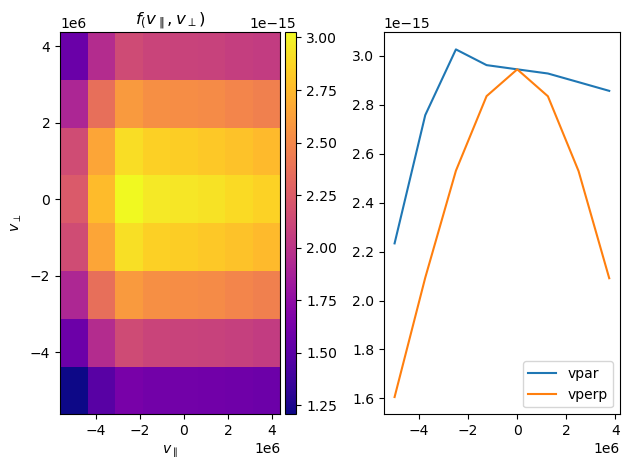

In [6]:
# Note He et al. ( https://doi.org/10.3847/1538-4357/ab9174 ) claim Tpar > Tperp due to dissipation of turbulence... could this just be adiabatic?  
# For instance: "In contrast, the electrons exhibit remarkable thermal anisotropy with Te_par > Te_perp at most times."

# See Tran & Sironi (2024) for electron simulations at a shock  --- very similar to what I'm trying to do
# "Electron Heating in 2D Particle-in-cell Simulations of Quasi-perpendicular Low-beta Shocks"
# Tran & Sironi wrote another very similar paper in 2020
# see also Sironi & Tran 2024 for another application

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


f = d['f']; vpar = d['vpar']; vperp = d['vperp']; x_f = d['x_f']; v_f = d['v_f']
filename = d['filename']; x = d['x']; v =d['v']

fig, ax = plt.subplots(1,2)
im = ax[0].pcolormesh(vpar, vperp, f,
                   cmap='plasma', shading='auto')
ax[0].set_xlabel(r'$v_\parallel$')
ax[0].set_ylabel(r'$v_\perp$')
ax[0].set_title(r'$f_(v_\parallel, v_\perp)$')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mycbar = fig.colorbar(im, cax=cax, orientation='vertical')

ax[1].plot(vpar[:,nv//2], f[:,nv//2], label = 'vpar')
ax[1].plot(vperp[nv//2,:], f[nv//2,:], label = 'vperp')
ax[1].legend()
plt.tight_layout()
plt.show()
#mycbar = ax.figure.colorbar(im)


In [7]:
x_f.shape
#x[0][0].shape


(8, 8, 3)

In [8]:

ni = f.shape[0]
nj = f.shape[1]
v_i_mag = np.zeros(f.shape)
v_f_mag = np.zeros(f.shape)
x_i = np.zeros(x_f.shape)

for i in range(ni):
    for j in range(nj):
        v_i_mag[i, j] = np.linalg.norm(v[i][j][0,:])
        v_f_mag[i, j] = np.linalg.norm(v_f[i,j,:])
        x_i[i,j,:] = x[i][j][0,:]
#v_i_mag = np.sqrt(vpar**2 + vperp**2)


energy_i = 0.5 * 9.1e-31 * v_i_mag**2 / 1.6e-19    # eV
energy_f = 0.5 * 9.1e-31 * v_f_mag**2 / 1.6e-19    # eV
energy_f

array([[114.04540477,  83.35591052,  59.79565963,  43.55542611,
         34.88348087,  34.07460463,  41.45133652,  57.35319117],
       [ 62.14030464,  36.27438198,  19.46939845,  11.54077576,
         12.31188425,  21.61164769,  39.27582306,  65.16091207],
       [ 88.75870931,  55.00401106,  29.17054462,  11.48993147,
          2.28184875,   1.96268163,  11.02320782,  30.01515639],
       [ 66.88970003,  41.20980703,  22.26976628,  10.05078407,
          4.56860578,   5.90575198,  14.20976306,  29.68844079],
       [ 83.11487082,  52.79975251,  29.7383068 ,  13.84045712,
          5.21900257,   4.17666471,  11.2087189 ,  27.01303764],
       [ 62.28550809,  37.68997341,  20.37659297,   9.92898427,
          5.98136021,   8.24339106,  16.60417441,  31.26718927],
       [ 90.0341095 ,  54.58300051,  28.39400602,  12.37257164,
          6.88872995,  11.84155216,  26.81101726,  51.22635757],
       [ 70.6537049 ,  46.93717149,  28.50206803,  15.60701004,
          8.68205309,   8.2857259

In [9]:
(energy_f - energy_i)[0,:]

array([-28.99897874, -28.62468973, -30.00787611, -32.95776387,
       -37.2260821 , -42.51805008, -48.51112869, -54.86580328])

In [10]:
x_f[3,5,:] / 6.371e6

array([1.62670483e+01, 3.43445031e-03, 2.97967900e+00])

In [11]:
print(vperp[0,:])
print(vpar[0,:])

[-5000000. -3750000. -2500000. -1250000.        0.  1250000.  2500000.
  3750000.]
[-5000000. -5000000. -5000000. -5000000. -5000000. -5000000. -5000000.
 -5000000.]


In [12]:
energy_i

array([[143.04438351, 111.98060025,  89.80353574,  76.51318998,
         72.10956297,  76.59265471,  89.9624652 , 112.21899445],
       [112.05791358,  80.99413032,  58.81706582,  45.52672006,
         41.12309305,  45.60618479,  58.97599528,  81.23252452],
       [ 89.95816241,  58.89437915,  36.71731464,  23.42696888,
         19.02334188,  23.50643362,  36.87624411,  59.13277335],
       [ 76.74512999,  45.68134673,  23.50428222,  10.21393646,
          5.81030945,  10.29340119,  23.66321168,  45.91974093],
       [ 72.41881631,  41.35503306,  19.17796855,   5.88762279,
          1.48399578,   5.96708752,  19.33689801,  41.59342725],
       [ 76.97922139,  45.91543813,  23.73837362,  10.44802786,
          6.04440086,  10.5274926 ,  23.89730309,  46.15383233],
       [ 90.42634522,  59.36256196,  37.18549745,  23.89515169,
         19.49152468,  23.97461642,  37.34442692,  59.60095616],
       [112.76018779,  81.69640454,  59.51934003,  46.22899427,
         41.82536726,  46.308459 

Text(0, 0.5, 'final energy')

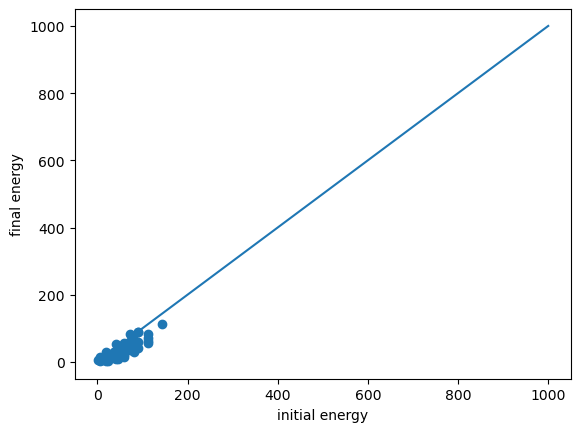

In [13]:
plt.scatter(energy_i, energy_f)
plt.plot([0,1000], [0,1000])
plt.xlabel('initial energy')
plt.ylabel('final energy')


In [14]:
# calculate the electric potential in the solar wind region
filename = get_filename(run, fileIndex)


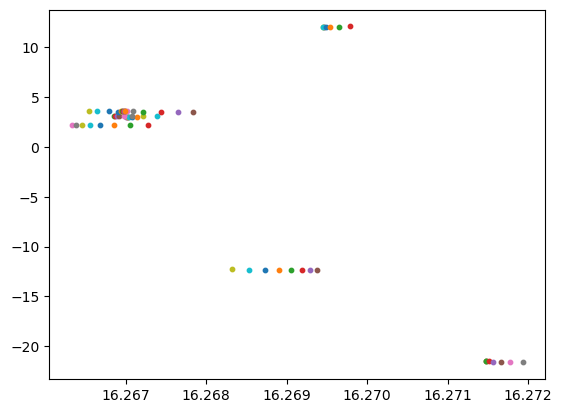

array([[-21.46427479, -21.48154574, -21.50177631, -21.52457396,
        -21.54949579, -21.57644486, -21.60572466, -21.63784316],
       [-12.291906  , -12.30520918, -12.31804369, -12.33057287,
        -12.3427696 , -12.35454464, -12.36593775, -12.37689152],
       [  2.21217487,   2.2081474 ,   2.20599586,   2.20573432,
          2.20743474,   2.21127022,   2.21749434,   2.2264852 ],
       [  2.97970618,   2.98021473,   2.98030076,   2.98022581,
          2.98004817,   2.979679  ,   2.97886927,   2.97712647],
       [  3.13301178,   3.14270616,   3.14782831,   3.1500277 ,
          3.15016207,   3.14849925,   3.14473699,   3.13801153],
       [  3.55449937,   3.56082008,   3.56542675,   3.56831826,
          3.56946504,   3.56885247,   3.56647933,   3.56236694],
       [  3.63444589,   3.59848817,   3.57720806,   3.5603506 ,
          3.5468723 ,   3.5381951 ,   3.53546225,   3.53968784],
       [ 12.07877035,  12.07080925,  12.06625362,  12.06498656,
         12.06695636,  12.0721283

In [34]:

# maybe this only works when run with sbatch
# the idea is to plot the magnetosphere, and the initial and final points 
'''
import pytools as pt
ax = plt.gca()
pt.plot.plot_colormap3dslice(filename=filename,var='proton/vg_rho', boxre=[-20, 20, -20, 20], normal ='z', run=run,
                             colormap='plasma',step=fileIndex,outputdir='/wrk-vakka/users/horakons/carrington/plots/{}/ptest/'.format(run),
                             outputfile='vg_rho_particle_trace_{}_{}.png'.format(run, str(fileIndex).zfill(5)),
                             Earth=1, streamlines='vg_b_vol', streamlinedensity=1, streamlinecolor = 'white', cutpointre=0, axes = ax, scale=1, useimshow=True)
'''

for i in range(nv):
    for j in range(nv):
        #plt.scatter(x_f[i,j,0]/R_EARTH, x_f[i,j,1]/R_EARTH)   # x-y
        plt.scatter(x_f[i,j,0]/R_EARTH, x_f[i,j,2]/R_EARTH, s =10)  # x-z

#plt.xlim([-15,15])

plt.show()
x_f[:,:,2]/R_EARTH

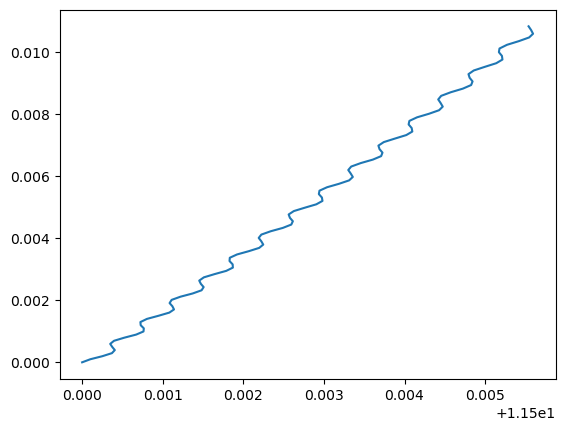

In [16]:
i = nv//2 +1; j = nv//2 +1

#plt.plot(x[i][j][:,0]/R_EARTH, x[i][j][:,1]/R_EARTH)  # x-y
plt.plot(x[i][j][0:100,0]/R_EARTH, x[i][j][0:100,2]/R_EARTH)  # x-z   (to show larmor motion)
#plt.plot(x[i][j][:,0]/R_EARTH, x[i][j][:,2]/R_EARTH)
#plt.plot(x[i][j][:,1]/R_EARTH, x[i][j][:,2]/R_EARTH)  # y-z

Text(0.5, 1.0, 'Backwards trajectories starting at [11.5  0.   0. ] (nonlocality)')

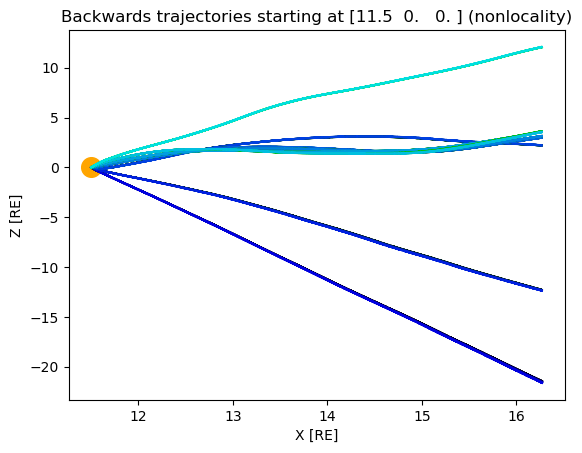

In [17]:

for i in range(nv):
    for j in range(nv):
        # ALL POSITIONS:
        #plt.plot(x[i][j][:,1]/R_EARTH, x[i][j][:,1]/R_EARTH)  # x-y
        plt.plot(x[i][j][:,0]/R_EARTH, x[i][j][:,2]/R_EARTH, color = (0, i/nv, j/nv))  # x-z
        #plt.plot(x[i][j][:,1]/R_EARTH, x[i][j][:,2]/R_EARTH)  # y-z
        # FINAL POSITION
        #plt.scatter(x[i][j][-1,0]/R_EARTH, x[i][j][-1,2]/R_EARTH, color = (0, i/nv, j/nv))  # x-z



plt.scatter(x[i][j][0,0]/R_EARTH, x[i][j][0,2]/R_EARTH, color = 'orange', s =200)
plt.xlabel('X [RE]')
plt.ylabel('Z [RE]')
#plt.xlim([12.5,13.5])


plt.title('Backwards trajectories starting at {} (nonlocality)'.format(x[0][0][0,:]/R_EARTH))


In [18]:

def phi_gradP(x, vlsvReader, n0 = 1e6):
    '''
    Inputs:
     x: 3-element coordinate vector or list
     vlsvReader: vlsvReader object

     PhiGradPe returns the potential Phi based on the density.
     Note when electrons follow adiabatic equation of state (EOS)
     grad Pe field is a potential field.
     Initial electron parameters (n0, T0) that set the EOS
     are found in .cfg file. But this function works for EGL, EGI, FHA

     Note: in EGL (and FHA?) n0=1e6 at early times and n0 = 4e6 at the end
    '''    
    elementalcharge = 1.6021773e-19
    kb = 1.38065e-23
    n = vlsvReader.read_interpolated_variable('proton/vg_rho', x)
    gamma = 5. / 3.
    T0 = kb * 5e5         # EGI, EGL [Joules]
    C = T0 * n0**(1. - gamma)
    return -(C / elementalcharge) * (gamma / (gamma - 1.)) * ( n**(gamma-1.) - n0**(gamma-1.) )


vlsvReader_file = get_vlsvfile_fullpath(run, fileIndex)
import ftest as ft
vlsvReader = ft.f(vlsvReader_file)

#phi_gradP(x_f[0,1], vlsvReader)
phi_gradP([13.5*R_EARTH,0,0], vlsvReader, n0 = 1e6)



Found population proton


-111.47497730711758

In [19]:
def phi_ExB(x, vlsvReader, x0 = [0,0,0], v0 = [-7.5e5, 0, 0], B0 = [0, 0, -5e-9]):
    #E would be nice to read the input data with vlsvReader.get_config(), but that doesn't seem to be working for EGI/EGL
    #measure ExB potential at x, with respect to the position x0, assuming uniform v and B fields 
    E_convec = -np.cross(np.array(v0), np.array(B0))  # for EGL, in +y direction
    deltax = np.array(x) - np.array(x0)
    return -np.dot(deltax, E_convec)


phi_ExB([11.5*R_EARTH, 0.01*R_EARTH,0], vlsvReader)   # for EGL, EGI, FHA, only the y-component matters


-238.91250000000002

In [20]:
print( phi_ExB(x_f[3,3], vlsvReader) )
print( phi_gradP(x_f[3,3], vlsvReader, n0 = 1e6) )
phi_gradP(x_i[i,j], vlsvReader, n0 = 1e6) 
phi_ExB(x_i[i,j], vlsvReader) 



-79.91398097729376
0.8803524817702011


-0.0

In [21]:
phi1 = phi_ExB(x_f, vlsvReader)
phi1 = phi1 - phi1[4,4]   # subtract the potential of the electron with v_i = 0, assumed to be moving on an equipotential
phi2 = phi1 * 0
for i in range(nv):
    for j in range(nv):
        phi2[i,j] = phi_gradP(x_f[i,j], vlsvReader, n0 = 1e6)  - phi_gradP(x_i[i,j], vlsvReader, n0 = 1e6)    

phi_tot = phi1 + phi2    # electric potential [volts]. Note phi2 is given as diff. between locations x_f and x_i, while phi1 is given as a presumed potential wrt a reference y-location. Note the ExB leading to phi1 is not required to be a potential field

phi1[4,4]

0.0

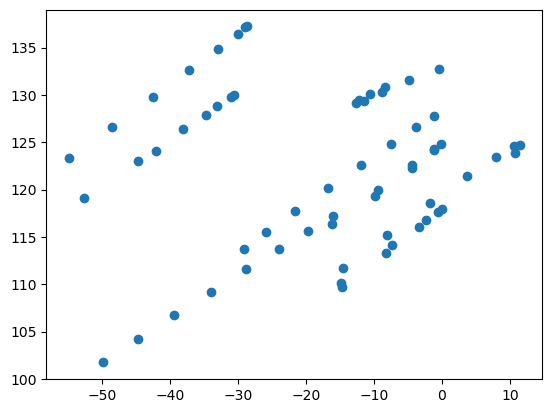

In [22]:
delta_energy = energy_f - energy_i
plt.close()
plt.scatter(delta_energy, phi_tot)

In [23]:
phi1
phi2

array([[121.43844621, 121.43857364, 121.4387219 , 121.43888794,
        121.4390684 , 121.43926254, 121.43947266, 121.43970261],
       [121.42889307, 121.42857135, 121.42826126, 121.42795895,
        121.42766512, 121.4273819 , 121.42710836, 121.42684585],
       [121.43015264, 121.43022847, 121.43027172, 121.43028211,
        121.43025824, 121.43019675, 121.4300928 , 121.42993928],
       [121.42057969, 121.42058064, 121.42058204, 121.42058299,
        121.42058345, 121.42058406, 121.42058613, 121.42059206],
       [121.41475097, 121.41437841, 121.41418151, 121.41409693,
        121.41409203, 121.41415706, 121.41430429, 121.41456762],
       [121.426396  , 121.42684232, 121.42716772, 121.42737176,
        121.4274521 , 121.42740758, 121.42723821, 121.42694596],
       [121.42972952, 121.42949278, 121.42801069, 121.42683877,
        121.42590443, 121.42530567, 121.42512061, 121.42541824],
       [121.43171086, 121.43178088, 121.43182079, 121.43183201,
        121.4318153 , 121.4317711

In [24]:
phi_gradP(x_i[5,5], vlsvReader, n0 = 1e6)

-120.54023050333036

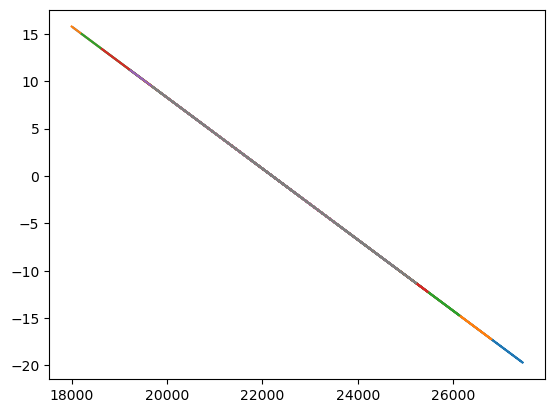

In [25]:
plt.plot(x_f[:,:,1], phi1)
plt.show()

In [26]:
x[0,0][106,:]/R_EARTH

TypeError: list indices must be integers or slices, not tuple

16.269783131137142